In [3]:
import plyvel
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
import itertools
from collections import defaultdict
import math

names = {1: "single", 2: "double", 3: "triple", 4: "quadruple"}

modname = "toml"

def rearrange_keys(d):
    ret = {}
    for k in d:
        if modname == "toml" and any(x in k for x in ("BAD_CIRCULAR_REF_CHECK", "STR_NO_LEADING_DOT")):
            continue
        ret["|".join(sorted(k.split("|")))] = d[k]
    return ret

def get_probs(to_shrink):
    bug_probs = defaultdict(lambda: [0, 0])
    for ncombos in range(1, 4):
        unshrunk_db = plyvel.DB(
            f"data/{modname}_{names.get(ncombos, 'x' + str(ncombos))}_{('unshrunk', 'shrunk')[to_shrink]}_ldb"
        )
        for seed in tqdm(range(1, 101)):
            key = str(seed).encode("utf8")
            unshrunk_data = rearrange_keys(json.loads(unshrunk_db.get(key)))
            for (k, bug) in unshrunk_data.items():
                bugs = set(k.split("|"))
                for l in range(1, len(bugs) + 1):
                    for bugset in itertools.combinations(bugs, l):
                        bugset = frozenset(bugset)
                        if bug["type"] == "nofail" or not all([x] in bug["triage"] for x in bugset):
                            bug_probs[bugset][1] += 500
                        else:
                            bug_probs[bugset][0] += 1
                            bug_probs[bugset][1] += bug["attempts"]
        unshrunk_db.close()

    bug_probs = {k: a / b for (k, [a, b]) in bug_probs.items()}
    return bug_probs

bug_probs = get_probs(False)
shrunk_probs = get_probs(True)
ratio_probs = {k: float("inf") if bug_probs[k] == 0 else shrunk_probs[k] / bug_probs[k] for k in bug_probs}

ratios = []
for ncombos in range(1, 4):
    unshrunk_db = plyvel.DB(
        f"data/{modname}_{names.get(ncombos, 'x' + str(ncombos))}_unshrunk_ldb"
    )
    shrunk_db = plyvel.DB(
        f"data/{modname}_{names.get(ncombos, 'x' + str(ncombos))}_shrunk_ldb"
    )
    for seed in tqdm(range(1, 101)):
        key = str(seed).encode("utf8")
        unshrunk_data = rearrange_keys(json.loads(unshrunk_db.get(key)))
        shrunk_data = rearrange_keys(json.loads(shrunk_db.get(key)))
        for k in unshrunk_data:
            unshrunk_entry = unshrunk_data[k]
            shrunk_entry = shrunk_data[k]
            if not (
                unshrunk_entry["type"] == shrunk_entry["type"]
                and (unshrunk_entry["type"] == "nofail" or unshrunk_entry["attempts"] == shrunk_entry["attempts"])
            ):
                print("rut roh")
                print(seed, k, unshrunk_entry, shrunk_entry)
                raise Exception("wtmoo")
            if unshrunk_entry["type"] != "fail":
                continue
            if any(len(x) > 1 for x in unshrunk_entry["triage"]) or any(len(x) > 1 for x in shrunk_entry["triage"]):
                continue
            preset = frozenset(x for [x] in unshrunk_entry["triage"])
            postset = frozenset(x for [x] in shrunk_entry["triage"])
            if bug_probs[preset] == 0:
                ratio = "infinity"
            else:
                ratio = bug_probs[postset] / bug_probs[preset]
            ratios.append(ratio)
    unshrunk_db.close()
    shrunk_db.close()

100%|██████████| 100/100 [00:00<00:00, 101.72it/s]


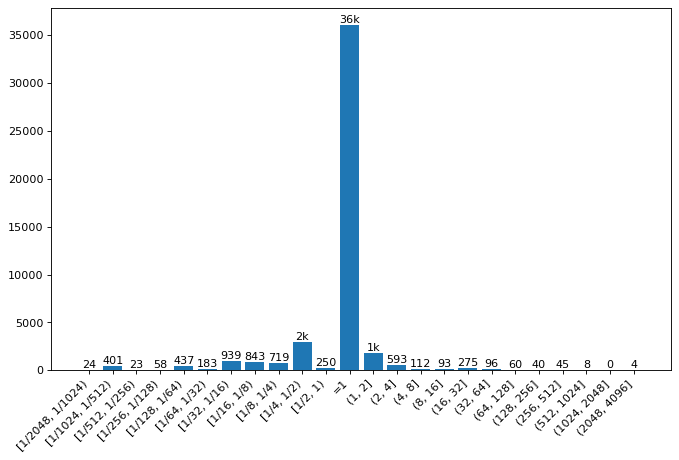

In [40]:
# print(bug_probs)

buckets = defaultdict(int)
infinity = 999999999
for ratio in ratios:
    if ratio == 0:
        continue
    if ratio == "infinity":
        buckets["infinity"] += 1

        continue
    log2 = math.log2(ratio)
    if log2 < 0:
        buckets[math.floor(log2)] += 1
    elif log2 > 0:
        buckets[math.ceil(log2)] += 1
    else:
        buckets[0] += 1

keys = [x for x in buckets.keys() if x != "infinity"]
for i in range(min(keys), max(keys) + 1):
    buckets[i]

buckets = dict(buckets)
(xs, ys) = list(zip(*sorted(buckets.items(), key=lambda x: 999999999 if x[0] == "infinity" else x[0])))

def format_log2(x):
    if x == "infinity":
        return "infinity"
    if x == 0:
        return "=1"
    if x > 0:
        return f"({2 ** (x - 1)}, {2 ** x}]"
    elif x == -1:
        return "[1/2, 1)"
    else:
        return f"[1/{2 ** (-x)}, 1/{2 ** (-x - 1)})"

def format_number(x):
    if x < 1000:
        return str(x)
    if x < 10000:
        return f"{x // 100 / 10}k"
    return f"{x // 1000}k"

plt.figure(figsize=(10, 6), dpi=80)

plt.bar([x * 3 for x in xs], ys, width=2.4)
plt.xticks([x * 3 for x in xs], [format_log2(x) for x in xs], rotation=45, ha="right")
for (x, y) in zip(xs, ys):
    plt.text(x * 3, y + 10, format_number(y), ha="center", va="bottom")
plt.show()

In [4]:
{list(k)[0]: v for (k, v) in bug_probs.items() if len(k) == 1}

{'DOT_DOESNT_UNESCAPE': 0.0012343737245634398,
 'FLOATS_TURN_TO_INTS': 0.003865304497682569,
 'FLOAT_DATETIME_CONFUSION': 2.2993313325501007e-05,
 'NO_DUMP_EMPTY_DICT_IN_LIST': 0.0004550089175105366,
 'NO_EMPTY_STRING_IN_LIST': 0.0015799397483088563,
 'NO_ESCAPE_KEYS': 0.005026988405243462,
 'NO_PARSE_ESCAPED_QUOTES': 0.00024196882513946,
 'NO_PARSE_LONE_QUOTE': 3.806064931467731e-05,
 'NO_QUOTES_IN_SECTION_NAME': 0.0004627436682300792,
 'NO_QUOTE_COMMA_IN_LIST': 8.651036678826678e-05,
 'NO_UNESCAPE_KEYS': 0.0397392953353183,
 'SECTION_NAME_NO_BRACKETS': 0.0004724242922954774,
 'STRINGS_SPLIT_EARLY': 0.0007528173490667549,
 'STR_DUMP_CANT_HANDLE_ESCAPE': 0.010392432217984911}